 # Diagnosing BioPCN

In [1]:
from types import SimpleNamespace
from functools import partial
import pydove as dv
import matplotlib as mpl

import torch

from tqdm.notebook import tqdm

from cpcn import *

 ## Setup

In [2]:
device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# this creates the loaders
batch_size = 100
dataset = load_mnist(n_validation=1000, batch_size=batch_size, device=device)

 ## Train BioPCN

In [3]:
n_batches = 6000
dims = [784, 5, 10]

z_it = 80
z_lr = 0.1
# rho = 0.015
rho = 0.0012

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * torch.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * torch.ones(len(dims) - 2)
g_b[0] *= 2

net = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    fast_optimizer=torch.optim.Adam,
    bias_a=False,
    bias_b=False,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.peek_validation(every=10)
trainer.set_classifier("linear")

initial_lr = 0.008
final_lr = initial_lr
trainer.set_optimizer(torch.optim.Adam, lr=initial_lr)
trainer.set_optimizer(torch.optim.SGD, lr=initial_lr)
# power = 0.8
# rate = (initial_lr / final_lr - 1) / (n_batches ** power)
# trainer.add_scheduler(
#     partial(
#         torch.optim.lr_scheduler.LambdaLR,
#         lr_lambda=lambda batch: 1 / (1 + rate * epoch ** power),
#     ),
#     every=1,
# )

trainer.set_lr_factor("Q", 20.0)

trainer.peek("weight", ["W_a", "W_b", "Q", "M"], every=10)
trainer.peek_sample("latent", ["z"])

trainer.peek_fast_dynamics(
    "fast",
    ["a", "b", "z", "n"],
    count=4,
    # sample_mask=torch.arange(batch_size) == batch_size - 1,
)

results = trainer.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/6000 [00:00<?, ?it/s]

 ## Check convergence of latent variables

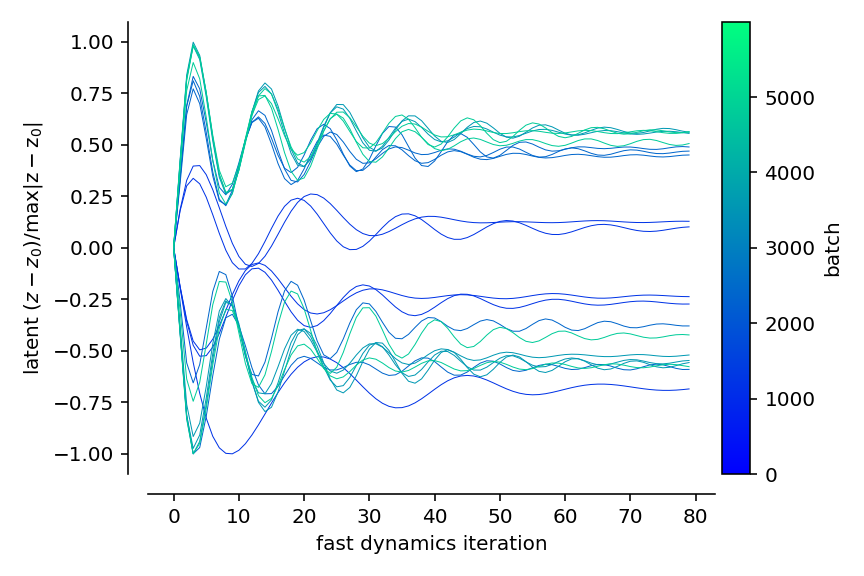

In [4]:
with dv.FigureManager() as (_, ax):
    show_latent_convergence(results.fast)

 ## Check whitening constraint in hidden layer

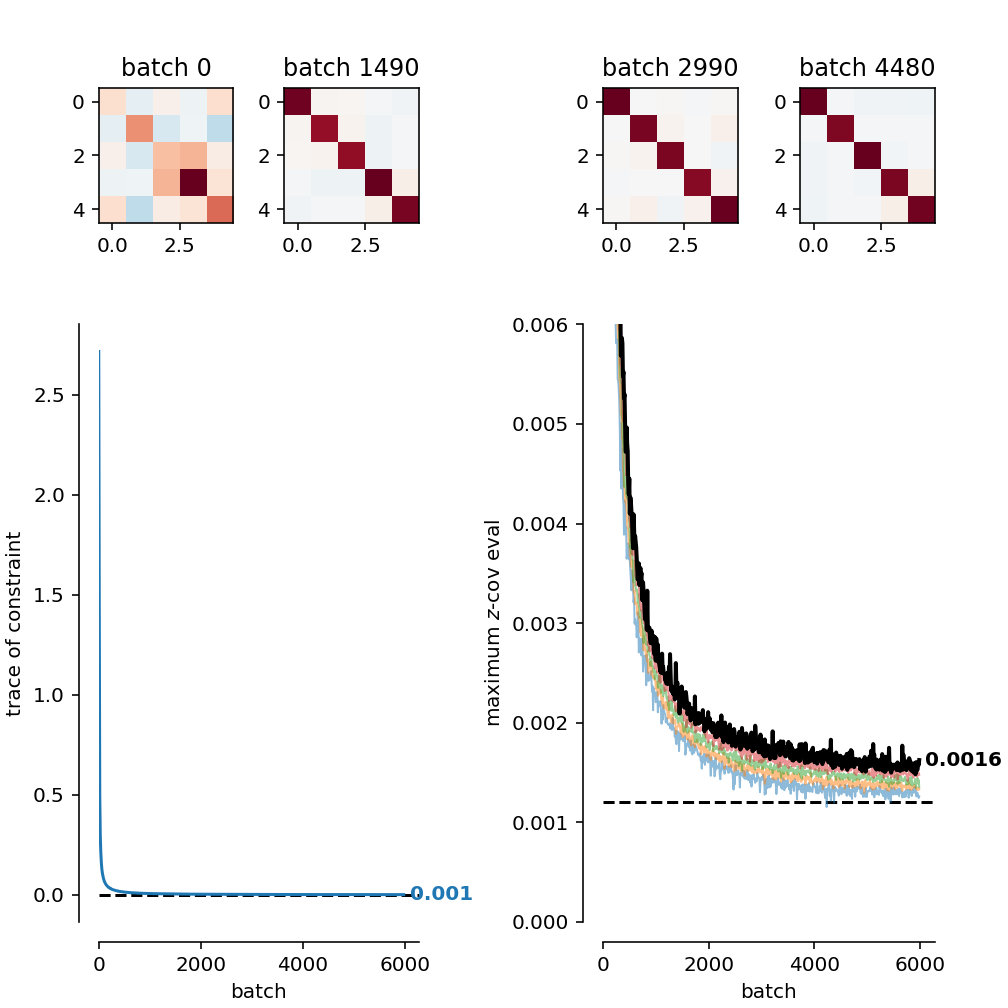

In [5]:
cons_diag = get_constraint_diagnostics(results.latent, rho=rho)
_ = show_constraint_diagnostics(cons_diag, rho=rho)

 ## Show loss and accuracy evolution

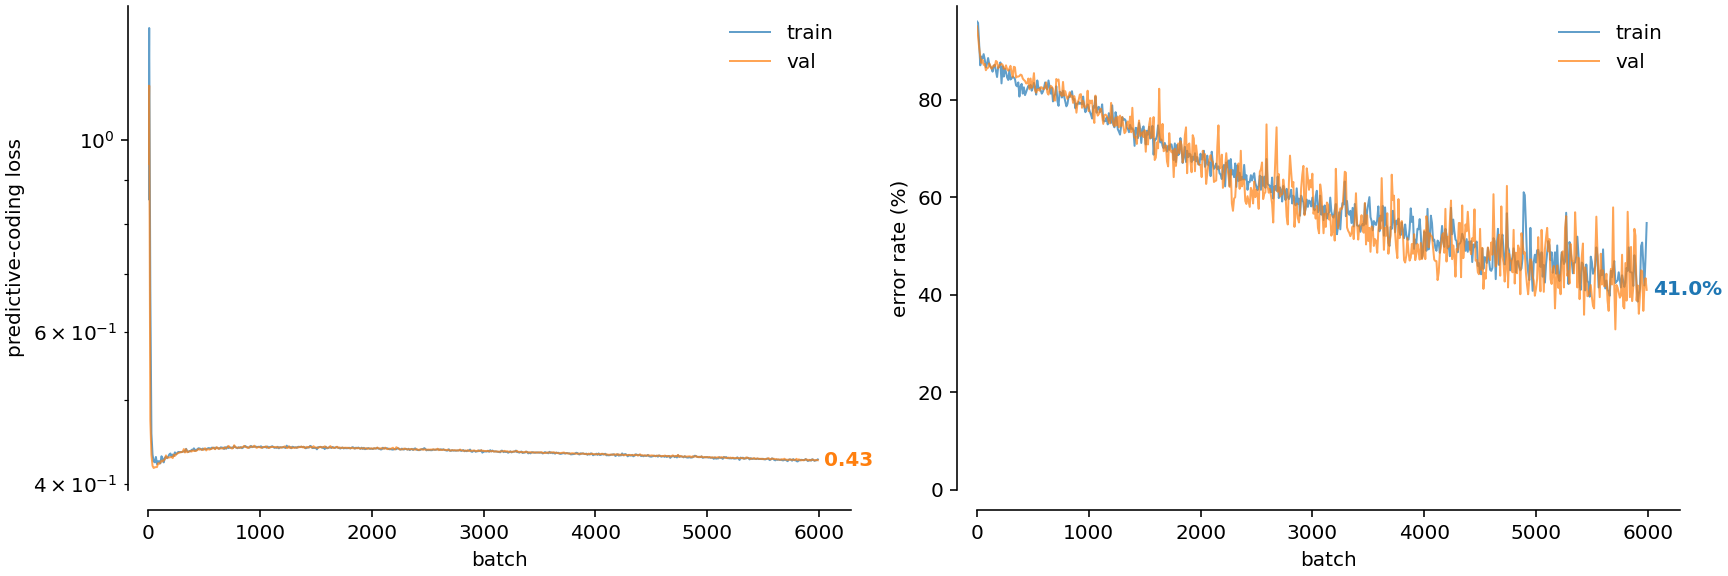

In [6]:
_ = show_learning_curves(results)

 ## Check weight evolution

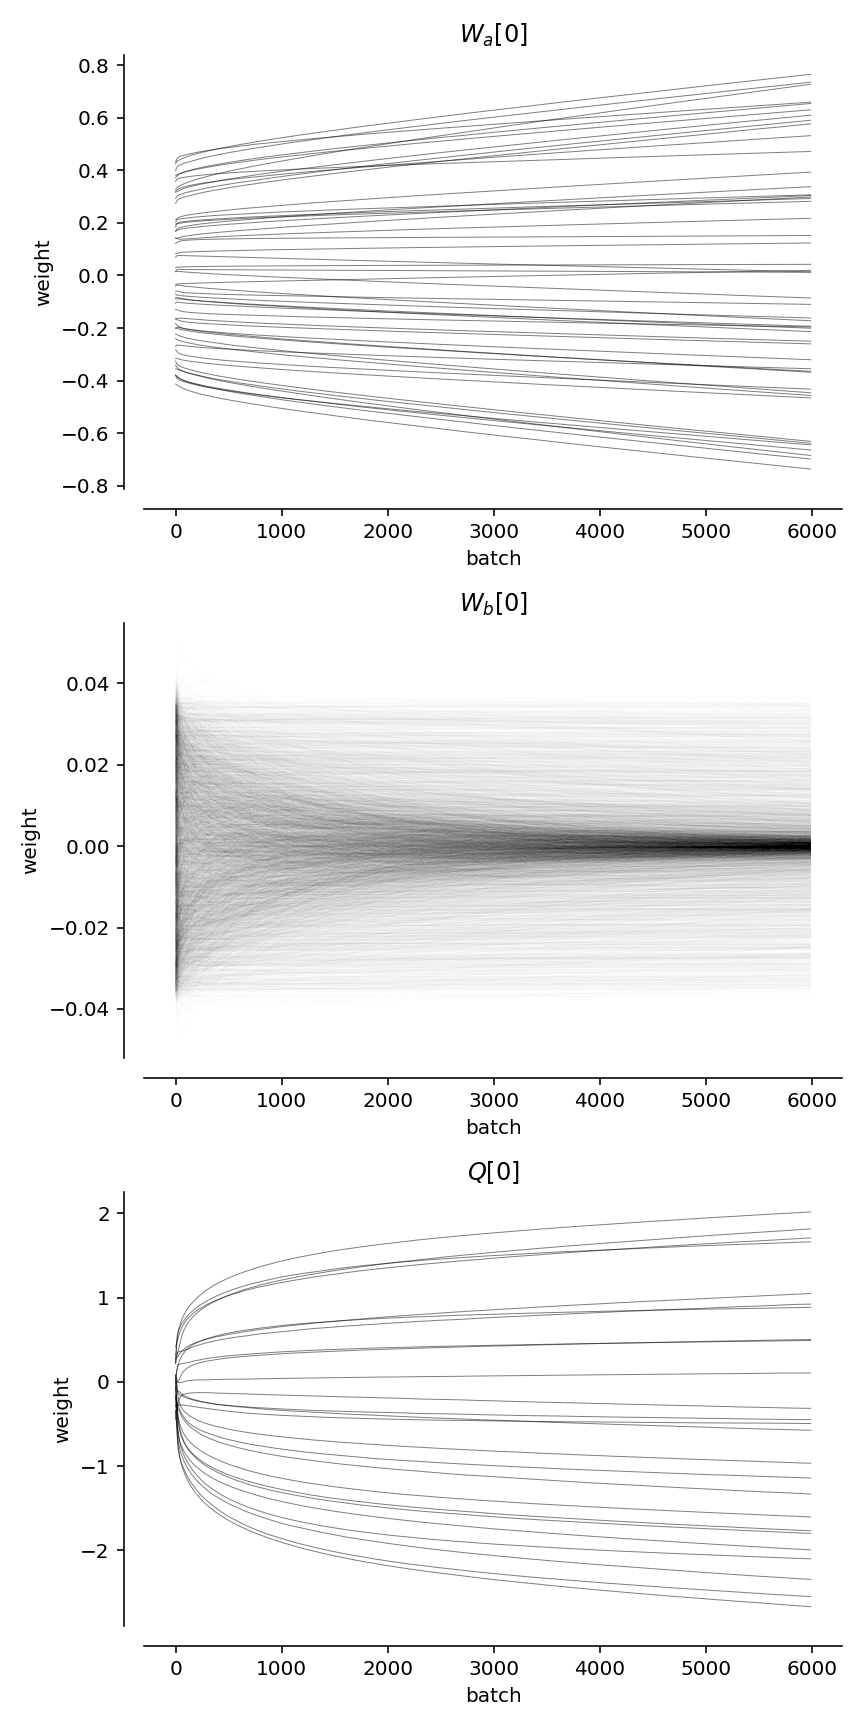

In [7]:
D = len(net.inter_dims)
with dv.FigureManager(3, D, squeeze=False) as (_, axs):
    for ax_row, w_choice in zip(axs, ["W_a", "W_b", "Q"]):
        for k, ax in enumerate(ax_row):
            show_weight_evolution(
                results.weight["batch"], results.weight[f"{w_choice}:{k}"], ax=ax
            )
            ax.set_title(f"${w_choice}[{k}]$")